# Mini Project: SVM &LR Classification

## MSDS 7331 Data Mining Section 404

### Chris Irwin, Damon Resnick, Josh Klein and Anna Frowein

## Creating the Models

We used the Zillow data set from Kaggle.com to investigate the differences between Logistic Regression and Support Vector Machine modeling.  *In taking a deeper look at the data we see that there is a a statistical difference with a p-value of .0554 between the values of homes with and without garages. The graph below we can see that there also seems to be a positive correlation between the number of garages and the log transformed tax value.*


F_onewayResult(statistic=3.289266677883695, pvalue=0.055416462903115575)

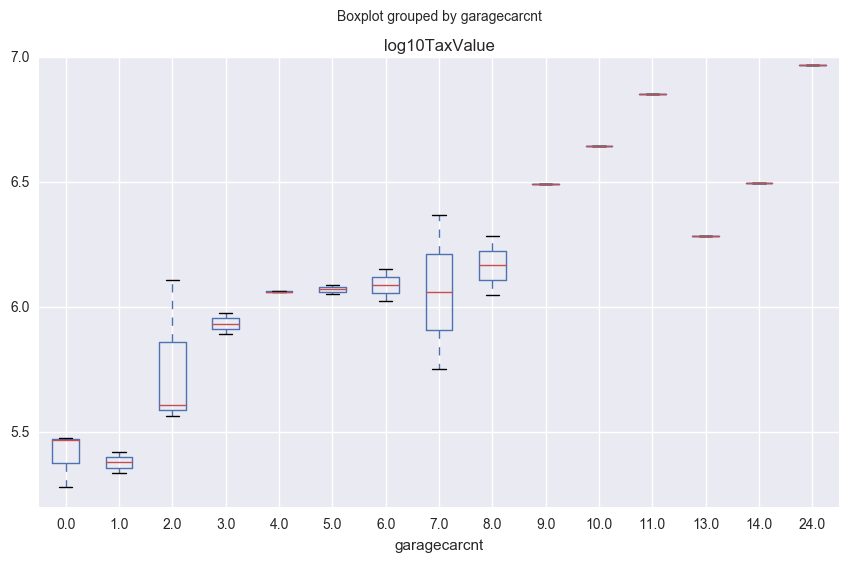

In [7]:
#Need to transform Tax Value because of large outliers
dfForModel['log10TaxValue'] = np.log10(dfFullTestData['taxvaluedollarcnt'])

avgValuebyBath = dfForModel.groupby(['countyname', 'garagecarcnt'], as_index = False)['log10TaxValue'].mean()

avgValuebyBath.boxplot('log10TaxValue', by='garagecarcnt', figsize=(10, 6))

LAGargageValue = avgValuebyBath[avgValuebyBath['countyname'] == 'Los Angeles County']
OCGargageValue = avgValuebyBath[avgValuebyBath['countyname'] == 'Orange County']
VentGargageValue = avgValuebyBath[avgValuebyBath['countyname'] == 'Ventura County'] 

import scipy.stats as stats

#print(garageCntZero)
stats.f_oneway(LAGargageValue['log10TaxValue'], OCGargageValue['log10TaxValue'], VentGargageValue['log10TaxValue'])


## Logistic Regression

In [9]:
# Load Pandas library
import pandas as pd

#Load numpy library
import numpy as np

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds

#Helps create 80/20 split 
from sklearn.model_selection import ShuffleSplit

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Allows for meterics to be found after Logistic Regression
from sklearn import metrics as mt

#Create KFolds for CV_Object
from sklearn.model_selection import KFold

#Creates Standard Scaler Variables
from sklearn.preprocessing import StandardScaler

#Support Vector Machine
from sklearn.svm import SVC


#Seaborn 
import seaborn as sb

#Magics for inline code.
%matplotlib inline

#Create Zillow Data Frame using Read_CSV
# read in the csv file
dfZillowData = pd.read_csv('/users/cmirwin/desktop/Smu Data Sets/Data Mining/ZillowData/Properties_2016.csv') 
#dfZillowData = pd.read_csv('/Users/joshuaklein/Desktop/properties_2016.csv')

dfTrainingData = pd.read_csv('/users/cmirwin/desktop/Smu Data Sets/Data Mining/ZillowData/train_2016.csv')
#dfTrainingData = pd.read_csv('/Users/joshuaklein/Desktop/train_2016_v2.csv')

#Create new data set that contains both the data zillow and the data to train against
dfFullTestData = pd.merge(dfTrainingData, dfZillowData, on='parcelid', how='left')

#Remove 2.9 million records from memory
del dfZillowData


#Get the headers to ensure all columns are included.
dfFullTestData.head(10)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,1.0,NaN,NaN,4.0,4.0,NaN,1.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,7.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.26,NaN,NaN,6.059063e+13


In [10]:
#We can see that a number of the data columns have NaN values that were assigned during import
#we choose to replace those values with the median values for the variable.

#Create new columns with highest missing values as True/False.
#print(dfMajorityOfDataMissing)

dfFullTestData['hasbasement'] = dfFullTestData[['basementsqft']].where(dfFullTestData[['basementsqft']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hasdeck'] = dfFullTestData[['yardbuildingsqft26']].where(dfFullTestData[['yardbuildingsqft26']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hasfireplace'] = dfFullTestData[['fireplaceflag']].where(dfFullTestData[['fireplaceflag']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hashottuborspa'] = dfFullTestData[['hashottuborspa', 'pooltypeid2']].where(dfFullTestData[['hashottuborspa','pooltypeid2']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['haspatio'] = dfFullTestData[['yardbuildingsqft17']].where(dfFullTestData[['yardbuildingsqft17']].isnull(), 1).fillna(0).astype(int)

#Create Function for County Rename
def rename(row):
    if row['regionidcounty'] == 1286:
        val = 'Ventura County'
    elif row['regionidcounty'] == 3101:
        val = 'Los Angeles County'
    else:
        val = 'Orange County'
    return val

dfFullTestData['countyname'] = dfFullTestData.apply(rename, axis=1)

print ('worked again')

worked again


In [11]:
#Create New data frame for everything
dfForModel = dfFullTestData.replace(to_replace='NaN',value= np.nan) 

#Get median values for based on original values
dfMedians = pd.DataFrame(dfFullTestData.median())

#Add Column Name to Medians DataFrame
dfMedians.columns = ['medianvalue']

#Create custom updates
dfColumns = pd.DataFrame(pd.Series([1.,0.,0.
                                    ,0.,0.,0.
                                    ,0.,0.,0.
                                    ,13.,5.,0.
                                    ,24.,0.,0.
                                    ,0.,0.,0.
                                    ,0.]
              , index=['numberofstories', 'bathroomcnt','bedroomcnt'
                      ,'fireplacecnt','fullbathcnt','garagecarcnt'
                      , 'poolcnt', 'roomcnt','unitcnt'
                      , 'heatingorsystemtypeid','airconditioningtypeid', 'garagetotalsqft'
                      , 'storytypeid', 'basementsqft', 'finishedsquarefeet13'
                      , 'finishedsquarefeet6','finishedsquarefeet15','finishedsquarefeet50'
                      , 'finishedfloor1squarefeet']))


#Set Column Name
dfColumns.columns = ['updatevalue']


#Create Merged Data set with values of both medians and custom
dfMerged = pd.concat([dfMedians, dfColumns], axis=1, join_axes=[dfMedians.index])

#Create new column of data that is custom values filled with median for any null
dfMerged['values'] = dfMerged['updatevalue'].fillna(dfMerged['medianvalue'])

#Apply median values to the overall data set
dfForModel = dfForModel.fillna(dfMerged['values'])

#Create smaller data set for descriptive stats section
dfDataForStats = dfForModel[['bathroomcnt',
                               'bedroomcnt',
                               'finishedfloor1squarefeet',
                               'calculatedfinishedsquarefeet',
                               'finishedsquarefeet15',
                               'lotsizesquarefeet',
                               'taxvaluedollarcnt',
                               'structuretaxvaluedollarcnt',
                               'landtaxvaluedollarcnt',
                               'taxamount']]

dfDataForStats.describe()


,bathroomcnt,bedroomcnt,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet15,lotsizesquarefeet,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
count,90811.000000,90811.000000,90811.000000,90811.000000,90811.000000,9.081100e+04,9.081100e+04,9.081100e+04,9.081100e+04,90811.000000
mean,2.266020,3.013974,101.768618,1770.112310,93.409840,2.653193e+04,4.569938e+05,1.796083e+05,2.778305e+05,5975.374056
std,1.016413,1.176174,398.691906,922.408353,508.302478,1.145533e+05,5.533113e+05,2.081280e+05,3.993632e+05,6819.341095
min,0.000000,0.000000,0.000000,2.000000,0.000000,1.670000e+02,2.200000e+01,1.000000e+02,2.200000e+01,49.080000
25%,2.000000,2.000000,0.000000,1189.000000,0.000000,5.973000e+03,1.999335e+05,8.178800e+04,8.291150e+04,2884.155000
50%,2.000000,3.000000,0.000000,1540.000000,0.000000,7.200000e+03,3.428720e+05,1.320000e+05,1.929700e+05,4542.750000
75%,3.000000,4.000000,0.000000,2084.000000,0.000000,1.032850e+04,5.383630e+05,2.093270e+05,3.440000e+05,6881.865000
max,20.000000,16.000000,7625.000000,22741.000000,22741.000000,6.971010e+06,2.775000e+07,9.948100e+06,2.450000e+07,321936.090000


In [13]:
#Create dummy variables for all TypeId columns
#This section takes a long time due to the fact that we are creating 
#so many additional variables by 3 million records. 

#heatingorsystemtypeid
#Create dynamic Name
dummies = pd.get_dummies(dfForModel['heatingorsystemtypeid']).rename(columns=lambda x: 'HSTypeId_' + str(x))
#Join to Dataframe for Model
dfForModel = pd.concat([dfForModel, dummies], axis=1)

#Delete from model 
#dfForModel.drop(['heatingorsystemtypeid'], inplace=True, axis=1)

#Repeat of code above
#airconditioningtypeid
dummies = pd.get_dummies(dfForModel['airconditioningtypeid']).rename(columns=lambda x: 'ACTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['airconditioningtypeid'], inplace=True, axis=1)

#architecturalstyletypeid
dummies = pd.get_dummies(dfForModel['architecturalstyletypeid']).rename(columns=lambda x: 'ArchStyleTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['architecturalstyletypeid'], inplace=True, axis=1)

#decktypeid
dummies = pd.get_dummies(dfForModel['decktypeid']).rename(columns=lambda x: 'DeckTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['decktypeid'], inplace=True, axis=1)

#buildingclasstypeid
dummies = pd.get_dummies(dfForModel['buildingclasstypeid']).rename(columns=lambda x: 'BuildClassTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['buildingclasstypeid'], inplace=True, axis=1)

#typeconstructiontypeid
dummies = pd.get_dummies(dfForModel['typeconstructiontypeid']).rename(columns=lambda x: 'ConstructionTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['typeconstructiontypeid'], inplace=True, axis=1)

#buildingqualitytypeid
dummies = pd.get_dummies(dfForModel['buildingqualitytypeid']).rename(columns=lambda x: 'BuildingQualTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['buildingqualitytypeid'], inplace=True, axis=1)

#propertylandusetypeid
dummies = pd.get_dummies(dfForModel['propertylandusetypeid']).rename(columns=lambda x: 'LandUseTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['propertylandusetypeid'], inplace=True, axis=1)

#Create Function for County Rename
def garagecnt(row):
    if row['garagecarcnt'] > 0:
        val = 1
    else:
        val = 0
    return val

dfForModel['hasgarage'] = dfForModel.apply(garagecnt, axis=1)


#Find out what data types are in the Data set
dfDataTypes = pd.DataFrame(dfForModel)

#Create Numeric Only Dataframe
dfZillowDataNumeric = dfDataTypes.select_dtypes(['float64','int64'])
 
print ('complete again')

complete again


In [26]:
#Create Cross Validation object and Test and train values
# we want to predict if a house has a garage
if 'hasgarage' in dfZillowDataNumeric:
    
    #Get the values for each property
    actualValues = dfZillowDataNumeric['hasgarage'].values 
    
    # get rid of the hasgarage variable
    del dfZillowDataNumeric['hasgarage'] 

    #delete any variables that give the model the possible anwser
    del dfZillowDataNumeric['garagecarcnt']
    del dfZillowDataNumeric['garagetotalsqft']
    
    
    # Gather all values to use for prediction
    additionalVars = dfZillowDataNumeric.values    

print ('groups created')

# Create cross validation with KFolds object
num_cv_iterations = 3
#Create Cross Validation objects using folds
cv_object = KFold(n_splits=num_cv_iterations, random_state=None, shuffle=True)
cv_object.get_n_splits(additionalVars)

for train_index, test_index in cv_object.split(additionalVars):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = additionalVars[train_index], additionalVars[test_index]
    y_train, y_test = actualValues[train_index], actualValues[test_index]
 
print ('Test and Train Data Created')
#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
stdsclrObj.fit(X_train) # find scalings for each column that make this zero mean and unit std

# to transform new feature data
# apply to training
X_train_scaled = stdsclrObj.transform(X_train)

# apply those means and std to the test set (without snooping at the test set values)
X_test_scaled = stdsclrObj.transform(X_test) 

# Create a reusable logisitic regression object
# the variable C is for Cost, penalty is actually a lowercase L and has 
# other options l1 and l2
logRegression = LogisticRegression(penalty='l2', C=.05, class_weight=None) # get object

# Using the CV Object we iterate through the folds.
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_train_scaled,y_train)):
    logRegression.fit(X_train_scaled[train_indices],y_train[train_indices])  # train object
    y_hat = logRegression.predict(X_train_scaled[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num + 1," ====")
    print("accuracy", mt.accuracy_score(actualValues[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(actualValues[test_indices],y_hat))

groups created
('TRAIN:', array([    0,     1,     3, ..., 90806, 90808, 90809]), 'TEST:', array([    2,     4,     5, ..., 90804, 90807, 90810]))
('TRAIN:', array([    0,     1,     2, ..., 90807, 90808, 90810]), 'TEST:', array([    6,     9,    10, ..., 90805, 90806, 90809]))
('TRAIN:', array([    2,     4,     5, ..., 90807, 90809, 90810]), 'TEST:', array([    0,     1,     3, ..., 90793, 90800, 90808]))
Test and Train Data Created
('====Iteration', 1, ' ====')
('accuracy', 0.55150884495317376)
('confusion matrix\n', array([[8902, 4642],
       [4409, 2228]]))
('====Iteration', 2, ' ====')
('accuracy', 0.55901883052527257)
('confusion matrix\n', array([[9040, 4495],
       [4404, 2241]]))
('====Iteration', 3, ' ====')
('accuracy', 0.55386521308225967)
('confusion matrix\n', array([[8931, 4608],
       [4395, 2246]]))


index value of  0 Variable Name:  regionidcounty has weight of -5.36848189095
index value of  1 Variable Name:  finishedsquarefeet12 has weight of -2.16869123997
index value of  2 Variable Name:  calculatedbathnbr has weight of -1.54937378562
index value of  3 Variable Name:  finishedsquarefeet15 has weight of -1.10515743952
index value of  4 Variable Name:  structuretaxvaluedollarcnt has weight of -1.09129404552
index value of  5 Variable Name:  regionidcity has weight of -0.736058846247
index value of  6 Variable Name:  lotsizesquarefeet has weight of -0.679311764785
index value of  7 Variable Name:  heatingorsystemtypeid has weight of -0.544578974776
index value of  8 Variable Name:  fullbathcnt has weight of -0.523842037682
index value of  9 Variable Name:  finishedsquarefeet6 has weight of -0.462219286329
index value of  10 Variable Name:  regionidzip has weight of -0.450248411252
index value of  11 Variable Name:  taxamount has weight of -0.338129185605
index value of  12 Variabl

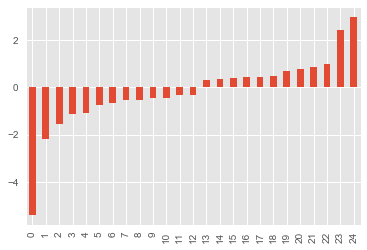

In [6]:
#Print results of last run.
# combine attributes
coefValues = zip(logRegression.coef_.T,dfZillowDataNumeric.columns) 

# sort these attributes and spit them out
coefValues = pd.DataFrame(sorted(coefValues))

#zip_vars.columns = ['values', 'names']

#keep all columns from dataframe with absolute values of .25 
dfValuesGTfive = coefValues.loc[abs(coefValues[0]) > .25]

#Reset Index from removing data
dfValuesGTfive = dfValuesGTfive.reset_index(drop=True)

#Remove any duplicate values from multiple runs
dfValuesGTfive = dfValuesGTfive.drop_duplicates([1], keep='last')

# iterate over the Variable values
#Get weight values
weights = dfValuesGTfive[0] 
#Get Variable Names
variable_names = dfValuesGTfive[1]
#Get Index count
indexes = dfValuesGTfive.index
#Combined the data set and then print out results
for index, weight, name in zip(indexes, weights,variable_names):
    print('index value of ', index , 'Variable Name: ', name, 'has weight of', weight[0])
    
#Due to the large number of variables we choose an absolute value of .15 as a cut off
#Show all variables with an absolute value of greater than .15
plt.style.use('ggplot')
#The commented line below give the correct labels, but not the correct values.
#plotweights = pd.Series(dfValuesGTfive[0].astype(float), index=variable_names)
plotweights = pd.Series(dfValuesGTfive[0].astype(float))
plotweights.plot(kind='bar')
plt.show()

## Support Vector Machine

In [2]:
# Load Pandas library
import pandas as pd

#Load numpy library
import numpy as np

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds

#Helps create 80/20 split 
from sklearn.model_selection import ShuffleSplit

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Allows for meterics to be found after Logistic Regression
from sklearn import metrics as mt

#Create KFolds for CV_Object
from sklearn.model_selection import KFold

#Creates Standard Scaler Variables
from sklearn.preprocessing import StandardScaler

#Support Vector Machine
from sklearn.svm import SVC


#Seaborn 
import seaborn as sb

#Magics for inline code.
%matplotlib inline

#Create Zillow Data Frame using Read_CSV
# read in the csv file
dfZillowData = pd.read_csv('/users/cmirwin/desktop/Smu Data Sets/Data Mining/ZillowData/Properties_2016.csv') 
#dfZillowData = pd.read_csv('/Users/joshuaklein/Desktop/properties_2016.csv')

dfTrainingData = pd.read_csv('/users/cmirwin/desktop/Smu Data Sets/Data Mining/ZillowData/train_2016.csv')
#dfTrainingData = pd.read_csv('/Users/joshuaklein/Desktop/train_2016_v2.csv')


#Create new data set that contains both the data zillow and the data to train against
dfFullTestData = pd.merge(dfTrainingData, dfZillowData, on='parcelid', how='left')

#Remove 2.9 million records from memory
del dfZillowData


#Get the headers to ensure all columns are included.
dfFullTestData.head(10)

/Users/cmirwin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,1.0,NaN,NaN,4.0,4.0,NaN,1.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,7.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.26,NaN,NaN,6.059063e+13


In [3]:
#We can see that a number of the data columns have NaN values that were assigned during import
#we choose to replace those values with the median values for the variable.

#Create new columns with highest missing values as True/False.
#print(dfMajorityOfDataMissing)

dfFullTestData['hasbasement'] = dfFullTestData[['basementsqft']].where(dfFullTestData[['basementsqft']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hasdeck'] = dfFullTestData[['yardbuildingsqft26']].where(dfFullTestData[['yardbuildingsqft26']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hasfireplace'] = dfFullTestData[['fireplaceflag']].where(dfFullTestData[['fireplaceflag']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['hashottuborspa'] = dfFullTestData[['hashottuborspa', 'pooltypeid2']].where(dfFullTestData[['hashottuborspa','pooltypeid2']].isnull(), 1).fillna(0).astype(int)

dfFullTestData['haspatio'] = dfFullTestData[['yardbuildingsqft17']].where(dfFullTestData[['yardbuildingsqft17']].isnull(), 1).fillna(0).astype(int)

#Create Function for County Rename
def rename(row):
    if row['regionidcounty'] == 1286:
        val = 'Ventura County'
    elif row['regionidcounty'] == 3101:
        val = 'Los Angeles County'
    else:
        val = 'Orange County'
    return val

dfFullTestData['countyname'] = dfFullTestData.apply(rename, axis=1)

print ('worked again')

worked again


In [16]:
#Create New data frame for everything
dfForModel = dfFullTestData.replace(to_replace='NaN',value= np.nan) 

#Get median values for based on original values
dfMedians = pd.DataFrame(dfFullTestData.median())

#Add Column Name to Medians DataFrame
dfMedians.columns = ['medianvalue']

#Create custom updates
dfColumns = pd.DataFrame(pd.Series([1.,0.,0.
                                    ,0.,0.,0.
                                    ,0.,0.,0.
                                    ,13.,5.,0.
                                    ,24.,0.,0.
                                    ,0.,0.,0.
                                    ,0.]
              , index=['numberofstories', 'bathroomcnt','bedroomcnt'
                      ,'fireplacecnt','fullbathcnt','garagecarcnt'
                      , 'poolcnt', 'roomcnt','unitcnt'
                      , 'heatingorsystemtypeid','airconditioningtypeid', 'garagetotalsqft'
                      , 'storytypeid', 'basementsqft', 'finishedsquarefeet13'
                      , 'finishedsquarefeet6','finishedsquarefeet15','finishedsquarefeet50'
                      , 'finishedfloor1squarefeet']))


#Set Column Name
dfColumns.columns = ['updatevalue']


#Create Merged Data set with values of both medians and custom
dfMerged = pd.concat([dfMedians, dfColumns], axis=1, join_axes=[dfMedians.index])

#Create new column of data that is custom values filled with median for any null
dfMerged['values'] = dfMerged['updatevalue'].fillna(dfMerged['medianvalue'])

#Apply median values to the overall data set
dfForModel = dfForModel.fillna(dfMerged['values'])

print('Data Created')


Data Created


In [17]:
#Create dummy variables for all TypeId columns
#This section takes a long time due to the fact that we are creating 
#so many additional variables by 3 million records. 

#heatingorsystemtypeid
#Create dynamic Name
dummies = pd.get_dummies(dfForModel['heatingorsystemtypeid']).rename(columns=lambda x: 'HSTypeId_' + str(x))
#Join to Dataframe for Model
dfForModel = pd.concat([dfForModel, dummies], axis=1)

#Delete from model 
#dfForModel.drop(['heatingorsystemtypeid'], inplace=True, axis=1)

#Repeat of code above
#airconditioningtypeid
dummies = pd.get_dummies(dfForModel['airconditioningtypeid']).rename(columns=lambda x: 'ACTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['airconditioningtypeid'], inplace=True, axis=1)

#architecturalstyletypeid
dummies = pd.get_dummies(dfForModel['architecturalstyletypeid']).rename(columns=lambda x: 'ArchStyleTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['architecturalstyletypeid'], inplace=True, axis=1)

#decktypeid
dummies = pd.get_dummies(dfForModel['decktypeid']).rename(columns=lambda x: 'DeckTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['decktypeid'], inplace=True, axis=1)

#buildingclasstypeid
dummies = pd.get_dummies(dfForModel['buildingclasstypeid']).rename(columns=lambda x: 'BuildClassTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['buildingclasstypeid'], inplace=True, axis=1)

#typeconstructiontypeid
dummies = pd.get_dummies(dfForModel['typeconstructiontypeid']).rename(columns=lambda x: 'ConstructionTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['typeconstructiontypeid'], inplace=True, axis=1)

#buildingqualitytypeid
dummies = pd.get_dummies(dfForModel['buildingqualitytypeid']).rename(columns=lambda x: 'BuildingQualTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['buildingqualitytypeid'], inplace=True, axis=1)

#propertylandusetypeid
dummies = pd.get_dummies(dfForModel['propertylandusetypeid']).rename(columns=lambda x: 'LandUseTypeId_' + str(x))
dfForModel = pd.concat([dfForModel, dummies], axis=1)
#dfForModel.drop(['propertylandusetypeid'], inplace=True, axis=1)

#Create Function for County Rename
def garagecnt(row):
    if row['garagecarcnt'] > 0:
        val = 1
    else:
        val = 0
    return val

dfForModel['hasgarage'] = dfForModel.apply(garagecnt, axis=1)


#Find out what data types are in the Data set
dfDataTypes = pd.DataFrame(dfForModel)

#Create Numeric Only Dataframe
dfZillowDataNumeric = dfDataTypes.select_dtypes(['float64','int64'])
 
print ('complete again')

complete again


In [22]:
#Create Cross Validation object and Test and train values
# we want to predict if a house has a garage
if 'hasgarage' in dfZillowDataNumeric:
    
    #Get the values for each property
    actualValues = dfZillowDataNumeric['hasgarage'].values 
    
    # get rid of the hasgarage variable
    del dfZillowDataNumeric['hasgarage'] 

    #delete any variables that give the model the possible anwser
    del dfZillowDataNumeric['garagecarcnt']
    del dfZillowDataNumeric['garagetotalsqft']

    # Gather all values to use for prediction
    additionalVars = dfZillowDataNumeric.values    


print ('groups created')

groups created


In [23]:

# Create cross validation with KFolds object
num_cv_iterations = 5
#Create Cross Validation objects using folds
cv_object = KFold(n_splits=num_cv_iterations, random_state=None, shuffle=True)
cv_object.get_n_splits(additionalVars)

#Create X and Y Train and Test Groups. 

for train_index, test_index in cv_object.split(additionalVars):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = additionalVars[train_index], additionalVars[test_index]
    y_train, y_test = actualValues[train_index], actualValues[test_index]
    
print ('Test and Train Data Created')

#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
stdsclrObj.fit(X_train) # find scalings for each column that make this zero mean and unit std

# to transform new feature data
# apply to training
X_train_scaled = stdsclrObj.transform(X_train)

# apply those means and std to the test set (without snooping at the test set values)
X_test_scaled = stdsclrObj.transform(X_test) 

print ('Scaled Data created')

#Run Support Vector Machine
from matplotlib import pyplot as svmplt
%matplotlib inline
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
#more info on Support Vector Machines is at the website below.
#https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/


#change between the Kernal test ‘rbf’, ‘poly’, 'linear', ‘sigmoid’
#only linear will produce a graph below. 
kernelTest = 'linear'

#gamma: Kernel coefficient for . Higher the value of gamma
#will try to exact fit the as per training data set i.e. generalization error and cause over-fitting problem.
#gammaLevel needs to be a float can also be auto
#altering this from Auto will create much longer run times.
gammaLevel = 'auto'

#C is the cost variable 
#Penalty parameter C of the error term. 
#It also controls the trade off between smooth decision boundary and classifying the training points correctly.
cost = .05

supportVectorCLF = SVC(C=cost, kernel=kernelTest, degree=3, gamma=gammaLevel) # get object
supportVectorCLF.fit(X_train_scaled, y_train)  # train object

y_hat = supportVectorCLF.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

('TRAIN:', array([    0,     1,     2, ..., 90807, 90809, 90810]), 'TEST:', array([    7,    10,    22, ..., 90801, 90806, 90808]))
('TRAIN:', array([    0,     2,     3, ..., 90806, 90807, 90808]), 'TEST:', array([    1,     5,     9, ..., 90804, 90809, 90810]))
('TRAIN:', array([    0,     1,     2, ..., 90808, 90809, 90810]), 'TEST:', array([    3,     6,    11, ..., 90792, 90796, 90807]))
('TRAIN:', array([    1,     3,     5, ..., 90808, 90809, 90810]), 'TEST:', array([    0,     2,     4, ..., 90791, 90802, 90803]))
('TRAIN:', array([    0,     1,     2, ..., 90808, 90809, 90810]), 'TEST:', array([    8,    17,    21, ..., 90798, 90799, 90805]))
Test and Train Data Created
Scaled Data created
('accuracy:', 0.98695077634621742)
[[12056   231]
 [    6  5869]]


index value of  0 Variable Name:  calculatedbathnbr has weight of -0.982328320116
index value of  1 Variable Name:  regionidcounty has weight of -0.754520832865
index value of  2 Variable Name:  finishedsquarefeet12 has weight of -0.748999544526
index value of  3 Variable Name:  finishedsquarefeet15 has weight of -0.408381246802
index value of  4 Variable Name:  finishedsquarefeet6 has weight of -0.309500633849
index value of  5 Variable Name:  rawcensustractandblock has weight of 0.114570524564
index value of  6 Variable Name:  fips has weight of 0.172678921704
index value of  7 Variable Name:  threequarterbathnbr has weight of 0.18439298667
index value of  8 Variable Name:  calculatedfinishedsquarefeet has weight of 0.78311633634
index value of  9 Variable Name:  bathroomcnt has weight of 1.01635686456


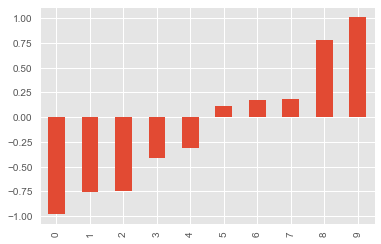

Support Vector Total:  (2810, 57)
Support Vector Indices:  (2810,)
Number of Support Vectors Per Class:  [ 949 1861]


In [21]:
if kernelTest == 'linear':
    #Print results of last run.
    # combine attributes
    coefValues = zip(supportVectorCLF.coef_.T,dfZillowDataNumeric.columns) 

    # sort these attributes and spit them out
    coefValues = pd.DataFrame(sorted(coefValues))

    #keep all columns from dataframe with absolute values of .05 
    dfValuesGTfive = coefValues.loc[abs(coefValues[0]) > .05]

    #Reset Index from removing data
    dfValuesGTfive = dfValuesGTfive.reset_index(drop=True)

    #Remove any duplicate values from multiple runs
    dfValuesGTfive = dfValuesGTfive.drop_duplicates([1], keep='last')

    # iterate over the Variable values
    #Get weight values
    weights = dfValuesGTfive[0] 
    #Get Variable Names
    variable_names = dfValuesGTfive[1]
    #Get Index count
    indexes = dfValuesGTfive.index
    #Combined the data set and then print out results
    for index, weight, name in zip(indexes, weights,variable_names):
        print('index value of ', index , 'Variable Name: ', name, 'has weight of', weight[0])

    #Due to the large number of variables we choose an absolute value of .15 as a cut off
    #Show all variables with an absolute value of greater than .15
    plt.style.use('ggplot')
    #The commented line below give the correct labels, but not the correct values.
    #plotweights = pd.Series(dfValuesGTfive[0].astype(float), index=variable_names)
    SVMweights = pd.Series(dfValuesGTfive[0].astype(float))
    SVMweights.plot(kind='bar')
    plt.show()
else:
        print ('No coefficient Data due to Kernal Type')

# look at the support vectors

#Support Vectors
print('Support Vector Total: ' , supportVectorCLF.support_vectors_.shape)

#Indices of support vectors
print('Support Vector Indices: ' , supportVectorCLF.support_.shape)

#Number of support vectors for each class.
print('Number of Support Vectors Per Class: ' ,supportVectorCLF.n_support_ )

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2810 entries, 13 to 90174
Data columns (total 58 columns):
parcelid                        2810 non-null int64
logerror                        2810 non-null float64
airconditioningtypeid           2810 non-null float64
architecturalstyletypeid        2810 non-null float64
basementsqft                    2810 non-null float64
bathroomcnt                     2810 non-null float64
bedroomcnt                      2810 non-null float64
buildingclasstypeid             2810 non-null float64
buildingqualitytypeid           2810 non-null float64
calculatedbathnbr               2810 non-null float64
decktypeid                      2810 non-null float64
finishedfloor1squarefeet        2810 non-null float64
calculatedfinishedsquarefeet    2810 non-null float64
finishedsquarefeet12            2810 non-null float64
finishedsquarefeet13            2810 non-null float64
finishedsquarefeet15            2810 non-null float64
finishedsquarefeet50         

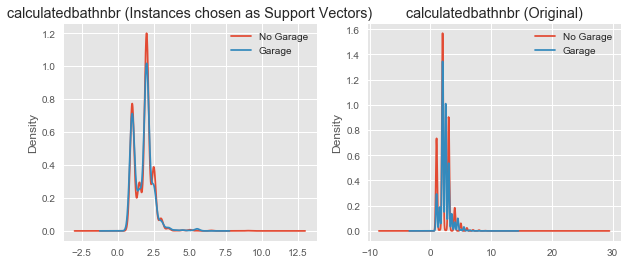

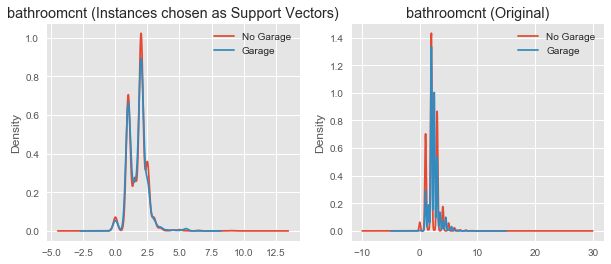

In [16]:
df_tested_on = dfZillowDataNumeric.iloc[train_index] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[supportVectorCLF.support_,:]

df_support['hasgarage'] = actualValues[supportVectorCLF.support_] # add back in the 'Survived' Column to the pandas dataframe
dfZillowDataNumeric['hasgarage'] = actualValues # also add it back in for the original data
df_support.info()

# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['hasgarage'])
df_grouped = dfZillowDataNumeric.groupby(['hasgarage'])

# plot KDE of Different variables
vars_to_plot = ['calculatedbathnbr', 'bathroomcnt']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['No Garage','Garage'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['No Garage','Garage'])
    plt.title(v+' (Original)')

## Additional SVM and Logistic Testing with Smaller Number of Variables

In [27]:
#Create smaller data set for descriptive stats section
dfDataForStats = dfForModel[['bathroomcnt',
                               'bedroomcnt',
                               'finishedfloor1squarefeet',
                               'calculatedfinishedsquarefeet',
                               'finishedsquarefeet15',
                               'lotsizesquarefeet',
                               'taxvaluedollarcnt',
                               'structuretaxvaluedollarcnt',
                               'landtaxvaluedollarcnt',
                               'taxamount', 
                               'hasgarage']]


#Create Cross Validation object and Test and train values
# we want to predict if a house has a garage
if 'hasgarage' in dfDataForStats:
    
    #Get the values for each property
    actualValues = dfDataForStats['hasgarage'].values 
    
    # get rid of the hasgarage variable
    del dfDataForStats['hasgarage'] 

    #delete any variables that give the model the possible anwser
    #del dfDataForStats['garagecarcnt']
    #del dfDataForStats['garagetotalsqft']

    # Gather all values to use for prediction
    additionalVars = dfDataForStats.values    

#print(additionalVars)
print ('groups created')

groups created


## Support Vector Machine

In [29]:


# Create cross validation with KFolds object
num_cv_iterations = 5
#Create Cross Validation objects using folds
cv_object = KFold(n_splits=num_cv_iterations, random_state=None, shuffle=True)
cv_object.get_n_splits(additionalVars)

#Create X and Y Train and Test Groups. 

for train_index, test_index in cv_object.split(additionalVars):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = additionalVars[train_index], additionalVars[test_index]
    y_train, y_test = actualValues[train_index], actualValues[test_index]
    
print ('Test and Train Data Created')

#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
stdsclrObj.fit(X_train) # find scalings for each column that make this zero mean and unit std

# to transform new feature data
# apply to training
X_train_scaled = stdsclrObj.transform(X_train)

# apply those means and std to the test set (without snooping at the test set values)
X_test_scaled = stdsclrObj.transform(X_test) 

print ('Scaled Data created')

#Run Support Vector Machine
from matplotlib import pyplot as svmplt
%matplotlib inline
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
#more info on Support Vector Machines is at the website below.
#https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/


#change between the Kernal test ‘rbf’, ‘poly’, 'linear', ‘sigmoid’
#only linear will produce a graph below. 
kernelTest = 'linear'

#gamma: Kernel coefficient for . Higher the value of gamma
#will try to exact fit the as per training data set i.e. generalization error and cause over-fitting problem.
#gammaLevel needs to be a float can also be auto
#altering this from Auto will create much longer run times.
gammaLevel = 'auto'

#C is the cost variable 
#Penalty parameter C of the error term. 
#It also controls the trade off between smooth decision boundary and classifying the training points correctly.
cost = .05

supportVectorCLF = SVC(C=cost, kernel=kernelTest, degree=3, gamma=gammaLevel) # get object
supportVectorCLF.fit(X_train_scaled, y_train)  # train object

y_hat = supportVectorCLF.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

('TRAIN:', array([    0,     1,     2, ..., 90808, 90809, 90810]), 'TEST:', array([    3,     7,    11, ..., 90799, 90801, 90802]))
('TRAIN:', array([    0,     1,     3, ..., 90808, 90809, 90810]), 'TEST:', array([    2,     4,    13, ..., 90778, 90785, 90806]))
('TRAIN:', array([    0,     2,     3, ..., 90806, 90807, 90809]), 'TEST:', array([    1,    20,    23, ..., 90804, 90808, 90810]))
('TRAIN:', array([    1,     2,     3, ..., 90808, 90809, 90810]), 'TEST:', array([    0,     5,    14, ..., 90792, 90795, 90805]))
('TRAIN:', array([    0,     1,     2, ..., 90806, 90808, 90810]), 'TEST:', array([    6,     8,     9, ..., 90800, 90807, 90809]))
Test and Train Data Created
Scaled Data created
('accuracy:', 0.74633850897478249)
[[12243    23]
 [ 4584  1312]]


## Logistic Regression

In [25]:
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
stdsclrObj.fit(X_train) # find scalings for each column that make this zero mean and unit std

# to transform new feature data
# apply to training
X_train_scaled = stdsclrObj.transform(X_train)

# apply those means and std to the test set (without snooping at the test set values)
X_test_scaled = stdsclrObj.transform(X_test) 

# Create a reusable logisitic regression object
# the variable C is for Cost, penalty is actually a lowercase L and has 
# other options l1 and l2
logRegression = LogisticRegression(penalty='l2', C=.05, class_weight=None) # get object

# Using the CV Object we iterate through the folds.
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_train_scaled,y_train)):
    logRegression.fit(X_train_scaled[train_indices],y_train[train_indices])  # train object
    y_hat = logRegression.predict(X_train_scaled[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num + 1," ====")
    print("accuracy", mt.accuracy_score(actualValues[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(actualValues[test_indices],y_hat))

('====Iteration', 1, ' ====')
('accuracy', 0.62863041982105983)
('confusion matrix\n', array([[8550, 1172],
       [4224,  584]]))
('====Iteration', 2, ' ====')
('accuracy', 0.63041982105987615)
('confusion matrix\n', array([[8575, 1143],
       [4227,  585]]))
('====Iteration', 3, ' ====')
('accuracy', 0.6366139022711631)
('confusion matrix\n', array([[8659, 1144],
       [4136,  591]]))
('====Iteration', 4, ' ====')
('accuracy', 0.62601514108740541)
('confusion matrix\n', array([[8535, 1156],
       [4278,  561]]))
('====Iteration', 5, ' ====')
('accuracy', 0.63046321150801843)
('confusion matrix\n', array([[8609, 1132],
       [4237,  551]]))


## Creating Models (continued)
### Logistic Regression
*Working with Logistic regression there are a number different parameters that can be used to enhance the quality of the model being built. We focused on 3 specific parameters Penalty, Cost and Class weight. Additionally, we used a parameter n_jobs, which is a performance enhancing variable and allows us to pick the number of cores we allow python to use during analysis.*

*The Penalty parameter has 3 possible values l1, l2 and str. We mainly focused on the l1 and l2 values for the purpose of our lab. The l1 and l2 penalty are a loss function that shows how well the estimates match the original value. The l1 penalty is a term based on least absolute deviations, which is the sum of the differences between the target value and the predicted. The l2 penalty term is based on the least squared error and helps better with large outliers. We tried both penalty values in our process and found that l2 gave us a better overall accuracy at 55.5% vs 54.4%. We believe this is due to the ability of the l2 penalty term to help account for outliers.*

*The Cost parameter is a value that allows a person to change the amount of regularization and helps with overfitting. We originally ran a baseline test with 1.0 as our cost parameter with an accuracy of 55.5%, but by changing the cost parameter to .05 we saw an almost 1% increase in our overall accuracy because of the ability to allow for a more generic model instead of being specific to the training dataset that was provided for testing.* 

*The Class weight parameter is a value that allows someone to account for the parameters and their importance. When you use the value of None all variables are treated with an equal weight of 1, but by changing the value to balanced then the weights are calculated by the function and given appropriate weights. We noticed that during testing the changing of this setting had a 1% decreased accuracy effect on our model, so we chose to keep the class weight parameter equal to None.*

*After trying multiple combinations, we found that for the best results with the given data set and using cross validation techniques were to use a penalty parameter of l2, a cost value of .05 and a class weight of None. *

### Support Vector Machines
*Second in our project we attempted to build a Support Vector Machine or SVM. SVM comes with multiple parameters similar to logistic regression, which we explained above, but SVM uses a kernel to help attempt to classify values. We mainly focused on three parameters kernel type, gamma and a cost parameter.*

*The Kernel type parameter allows you to choose from 4 different kernels. These different kernels allow for the model to do complex calculations for higher dimensional data on a much more efficient basis. We originally tried a linear kernel, which produced a larger amount of feedback once the regression was completed, most importantly we had access to data that helped in the creation of the graphs that were included above. *

*The Gamma parameter helps with the overfitting. In general, the higher the value of gamma leads to models that tend to have high bias and low variance. We set the value of Gamma equal to auto, which produced very good results. Interesting enough in attempting to change the Gamma value we found that the amount of time it took to produce a model was increase significantly. After multiple attempts, we choose to keep the Gamma value as auto. *

*The Cost parameter is a penalty parameter that corresponds to an error term. The cost parameter also controls the influence of each individual vector, which helps with the tradeoff between smooth decision boundary and classifying the training dataset. We found that by setting the cost to 1.0 the amount of time to complete the SVM model was almost 3 times higher than a lower cost .05. *

*Finally, we decided on a SVM model that had a kernel parameter of linear, cost parameter of .05 and Gamma parameter of auto. These settings created an overall model accuracy of approximately 98% when using cross validation.*



## Advantages of Models

*After the completion of multiple runs through both Support Vector Machine and Logistic Regression as a group we feel that that Support Vector Machine is a better tool for classification. During our analysis, the Support Vector Machine model once complete had a higher accuracy, approximately 99% accuracy rate, in predicting the existence of a garage on a property when compared to the Logistic Regression Models, which achieved an accuracy rate of approximately 55%.*

*In order to validate the Support Vector Machine’s ability to classify better we did an additional test with a considerably smaller data set in terms of columns and the result was still higher with approximately 75% correctly classified. Interestingly enough the Logistic Regression Model also improved to approximately 63% when using the data set with less columns. In our team’s opinion, there could be two possible reasons for these outcomes. First our overall data set has a very large number of variables and we did not do any type of dimension reduction before passing the values through both regression models. This could of lead to a large amount of noise that was much more difficult for the Logistic Regression to correctly classify with. The second possible reason could have been that in our initial data set we did not remove all the references to a garage and the Support Vector Machine model was in turn inadvertently given the answer, by using a smaller number of columns we were able to validate that these reasons were most likely the reason for the 40-point increase in correct classifications between the two models.*

*The performance of the two models is very different in terms of both time and accuracy. Logistic Regression was a much faster overall classifier, but the lower accuracy was outweighed by any time or CPU savings. Additionally, the Support Vector Machine model took a longer amount of time, but has the ability to be much greater of a classifier. This was shown by the ability of the model to use considerably less input to create a better overall classifier.  *


## Weights From Logistic Regression

Most of the variables related to size of the residence have a positive weighting in the logistic regression model. Bedroomcnt, bathroomcnt, and calculatedfinshedfloorsquareft all point to larger houses having more impact to the prediction if a house has a garage. The trend in real estate has been that new houses are being built each year with increasing average size and these 3 measures along with yearbuilt lend support to that notion. 

The positive weighting for yearbuilt is also correlated with the understanding that as cars became more popular and almost a necessity in our society, the need for a garage has also increased.

Propertylandusetypeid gives us a value that corresponds to the type of property (e.g. condominium, single family residential, duplex, etc) and this would play into determining the probability of a residence having a garage. Certain types such as vacant land and planned unit development would most likely not contain a garage, but a condominium or single family residence would have a high probability to contain a garage.

On the negative weighting side, the model contains multiple variables that are general area descriptors such as regionidcounty (county name), regionidcity (city name), and regionidzip (zip code). These are very large geographic classification variables that would not be able to accurately predict garages. A random pick of a residence in any one of those would most likely show a garage which doesn’t make these reliable predictors. However, more precise measures of location could be better predictors with newer locations of residential growth (i.e. urban sprawl) having a higher probability of containing a garage. Variables supporting this thought include parcelid, censustractandblock, longitude, and latitude. Each one of these provide greater precision to an exact location over the macro-variables of county, city, and zip and all show positive weightings to the model.

The overarching theme to the model shows variables related to specific location, age, and size of a property provide more weight to the model in predicting if a garage is present.


## Support Vectors Classification Task

When looking to predict if a certain parcel of land has a garage using a support vector machine method for classification, the resulting vectors do provide some insight into the data. Locality at a macro level, the county location, shows a very negative correlation to if the property has a garage. The data is heavily weighted with Los Angeles County properties which tend to be older and were built closer to the infancy of the automobile and the need for a garage. Growth in the region would have spread to the edges of LA County and the other 2 counties in the study in parallel to the popularity of automobiles and the need for a garage. On the positive correlation side there are 2 support vectors related to overall size of the property - calculatedfinishedsquarefeet and bathroomcnt. These tell us that the larger the size of property the more likely it has a garage. Properties such as condominiums and office buildings would be on the higher side of both of these and just from casual observation it would be highly understandable for these kinds of properties to probably have a garage. Another aspect of increasing property size are newer houses. The average size of a typical residence has increased throughout the years, again in parallel with rising automobile popularity and the need for a garage.    

